# Model Iteration 1 for Movie Sentiment Analysis

## Yuzhong Huang & Wilson Tang

## Data Description
"There's a thin line between likably old-fashioned and fuddy-duddy, and The Count of Monte Cristo ... never quite settles on either side."

The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee. In their work on sentiment treebanks, Socher et al. used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

## Exploration Journal Debrief

We first followed the bag of words kaggle tutorial(https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) to create a (256060, 1000) bag of words as a feature map, and applied random forest classification to fit our trainning data. Due to limitedness of memory, we were only able to perform random forest classification at tree level of 10. And we achieved score of 0.56750 in Kaggle.

After our first submission, we want to take control over the words in original bag of words based on the results in our data exploration. Therefore, we wrote our own bag of words.  

## Bag of Words

To generate a bag of words, we need to do some level of data cleaning beforehand. It would be sad if some of the common meaningless stop words like "the", "a" becomes the features of our bag of word. After that, we will use scikit-learn's bag of words tool "CountVectorizer" to generate a vectorizer of 1000 words. By using the bag of words, we then use random forest classification of level 10 to fit our training bag of words. 

After following the tutorial, we want to incorporate our discoverings from data exploration to the bag of words. Specifically, we wanted to filter out words of high standard deviation while keeping those with high frequency.

We first import both train and test data and drop "Nan" entries for basic data cleaning 

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import thinkstats2
import thinkplot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
%matplotlib inline
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

/home/yuzhong/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/yuzhong/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuzhong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get train & test csv files as a DataFrame
train = pd.read_csv("train.tsv", sep='\t')
test = pd.read_csv("test.tsv", sep='\t')

# drop nan data in train
train = train.dropna()
test = test.dropna()
train.describe()
test.describe()

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


Now we will do preprocessing on the two datasets by removing punctuation, converting a review into set of words, converting to lowercase, and removing "stop words" using nltk resouces. The movie processed reviews will be added as a new column to the original dataframe 

In [3]:
def review_to_words(review):
    """ This function will take in a loaded review as well as a list of stop words and process it by
    removing non letters, converting to lowercase and splitting, removing stopwords, and 
    returning a reconstructed review
    """
    letters_only = re.sub("[^a-zA-Z]", " ", review)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return ( " ".join(meaningful_words ))

def add_processed_review(df):
    """ add_processed_review takes a dataframe and process the phrases within the dataframe and 
    add a new column "ProcessedReview".
    """
    df['ProcessedReview'] = df['Phrase'].apply(review_to_words)
    return df

train = add_processed_review(train)
test = add_processed_review(test)

Now that we have our training reviews tidied up, we are going to create a bag of words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears.

In the IMDB data, we have a very large number of reviews, which will give us a large vocabulary. To limit the size of the feature vectors, we should choose some maximum vocabulary size. Below, we use the 1000 most frequent words (remembering that stop words have already been removed).

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 4000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train['ProcessedReview'].tolist())

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

Now that we created a bag of words from training dataset, we will use random forest classification to fit a basic model. Due to the limitedness of our computer's RAM, we set n_estimators to be 10, rather than 100 as suggested. 

In [6]:
# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 10) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, train["Sentiment"] )

Perform the same operation for test dataset and make a submission for Kaggle "Movie_Sentiment_Analysis_Submission.csv"

In [7]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test['ProcessedReview'].tolist())
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

def submission(predictions):
    """
    Use pandas to write the comma-separated output 
    file based on the predictions
    """
    
    submission = pd.DataFrame({
            "PhraseId": test["PhraseId"],
            "Sentiment": predictions
        })

    submission.to_csv("Movie_Sentiment_Analysis_Submission.csv", index=False, quoting=3)

# Use pandas to write the comma-separated output file
submission(result)

By submitting the file to Kaggle, we get a score of 0.56750. From here, we then want to implement our own bag of words to generates a better bag of words based on our data explorations.

In [8]:
def word_df(df):
    """
    Create a dataframe documenting the frequency, standard deviation and 
    mean value of each unique word appears in the given dataframe  
    """
    word_dict = {}
    for index, row in df.iterrows():
        list = review_to_words(row["Phrase"]).split()
        sentiment = row["Sentiment"]
        
        for word in list:
            if word in word_dict:
                word_dict[word][0] += 1
                word_dict[word][1].append(sentiment)
            else:
                word_dict[word] = [1, [sentiment]]
    
    word_df = pd.DataFrame(word_dict.items(), columns=["Word", "Frequency-Sentiment"])
    word_df['Frequency'] = word_df['Frequency-Sentiment'].apply(lambda x: x[0])
    word_df['Sentiment'] = word_df['Frequency-Sentiment'].apply(lambda x: np.mean(x[1]))
    word_df['Std'] = word_df['Frequency-Sentiment'].apply(lambda x: float(np.std(x[1])))
    return word_df.drop('Frequency-Sentiment', 1).dropna().sort_values(['Frequency'], ascending=False)

# generate a word dataframe for train dataset
train_word_df = word_df(train)

/home/yuzhong/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


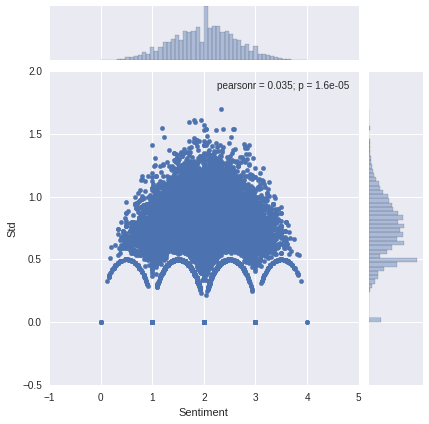

In [9]:
# jointplot of sentiment 
sns.jointplot(train_word_df['Sentiment'], train_word_df['Std']);

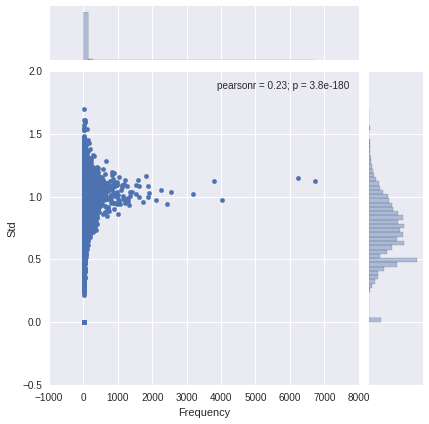

In [10]:
sns.jointplot(train_word_df['Frequency'], train_word_df['Std']);

Based on the distribution of standard deviation and frequency for our training data set, we pick words that have frequency higher than 30 and standard deviation smaller than 0.8, which will gives us more accurate and meanful information in deciding the sentiment of phrases

In [25]:
train_bag_word_df = train_word_df[(train_word_df['Frequency'] > 30) & (train_word_df['Std'] < 0.8)]

In [29]:
def select_review_to_words(review):
    """ This function will take in a loaded review as well as a list of stop words and process it by
    removing non letters, converting to lowercase and splitting, removing stopwords, and 
    returning a reconstructed review
    """
    letters_only = re.sub("[^a-zA-Z]", " ", review)
    words = letters_only.lower().split()
    select = set(train_bag_word_df["Word"].tolist())
    meaningful_words = [w for w in words if w in select]
    return ( " ".join(meaningful_words ))

def add_select_processed_review(df):
    """ add_processed_review takes a dataframe and process the phrases within the dataframe and 
    add a new column "ProcessedReview".
    """
    df['ProcessedReview'] = df['Phrase'].apply(lambda x: select_review_to_words(x))
    return df

train_t = add_select_processed_review(train)
test_t = add_select_processed_review(test)

In [36]:
train_t_data_features = vectorizer.fit_transform(train_t['ProcessedReview'].tolist())

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_t_data_features = train_t_data_features.toarray()

In [39]:
forest = forest.fit( train_t_data_features, train_t["Sentiment"] )

In [40]:
# Get a bag of words for the test set, and convert to a numpy array
test_t_data_features = vectorizer.transform(test_t['ProcessedReview'].tolist())
test_T_data_features = test_t_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_t_data_features)

In [42]:
# Use pandas to write the comma-separated output file
submission(result)

We only got about 0.54 by using our own word list. I think the reason is that we only cares about frequency and standard deviation, sklean's countvector may have a more comprehensive word list 

Next, we will try applying tfidf tool over the bag of word and change words to lemma so that we focus more on the meaning of the word rather than the form of word.

In [7]:
def split_into_lemmas(message):
    """
    Using TextBlob to get the root of words in a given sentence and return a list of lemmas
    
    Examples:
    split_into_lemmas("eating meals") == ['eat', 'meal']
    """
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

def lemmas_review_to_words(review):
    """ This function will take in a loaded review as well as a list of stop words and process it by
    removing non letters, converting to lowercase and splitting, removing stopwords, and 
    returning a reconstructed review
    """
    letters_only = re.sub("[^a-zA-Z]", " ", review)
    words = split_into_lemmas(letters_only)
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return ( " ".join(meaningful_words))

def add_lemmas_processed_review(df):
    """ add_processed_review takes a dataframe and process the phrases within the dataframe and 
    add a new column "ProcessedReview".
    """
    df['ProcessedReview'] = df['Phrase'].apply(lemmas_review_to_words)
    return df

train_l = add_lemmas_processed_review(train)
test_l = add_lemmas_processed_review(test)

In [23]:
train_l_data_features = vectorizer.fit_transform(train_l['ProcessedReview'].tolist())

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_l_tfidf = TfidfTransformer().fit_transform(train_l_data_features)
train_l_tfidf = train_l_tfidf.toarray()

In [24]:
forest = RandomForestClassifier(n_estimators = 10) 
forest = forest.fit(train_l_tfidf, train_l["Sentiment"])

In [25]:
# Get a bag of words for the test set, and convert to a numpy array
test_l_data_features = vectorizer.transform(test_l['ProcessedReview'].tolist())
test_l_tfidf = TfidfTransformer().fit_transform(test_l_data_features)
test_l_tfidf = test_l_tfidf.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_l_tfidf)

In [27]:
# Use pandas to write the comma-separated output file
submission(result)

We got about 0.56533 by using tfidf, which is slightly lower than what we got before.

In [32]:
nb = MultinomialNB().fit(train_l_data_features, train_l["Sentiment"])
result = nb.predict(test_l_data_features)
submission(result)

We got about 0.55569 by using navie bayes with tfidf, which is lower than what we got before. But if we just count the frequency of the words for bag of words, we get 0.57274 in Kaggle, which is better than that combination with random forest


Next step is to incorporate our findings with length and relationship between sentences and phrases to our current best modeling: navie bayes with frequencet of bag of words. Specifically, we are going to have seperate data for whole sentences and single phrases. We will first model whole sentences and then apply length and sentences's sentiment

In [5]:
def add_whole_sentence(df):
    """
    Generates a boolean 'WholeSentence' column for given dataset
    to indicate whether the phrase is a whole sentence or not
    """
    df['WholeSentence'] = False
    # initialize a last_id for comparison
    last_id = 0
    # loop throught the dataframe to set the first sentence for each sentence group's 'WholeSentence' to be True
    for index, row in df.iterrows():
        # changes 'WholeSentence' to be true for the first sentence for each sentence group
        if last_id != row['SentenceId']:
            last_id = row['SentenceId']
            df.set_value(index, 'WholeSentence', True)
    return df 

train = add_whole_sentence(train)
test = add_whole_sentence(test)
train_sentence =  train[train['WholeSentence'] == True]
test_sentence =  test[test['WholeSentence'] == True]

In [6]:
train_s_data_features = vectorizer.fit_transform(train_sentence['ProcessedReview'].tolist())
train_s_data_features = train_s_data_features.toarray()
test_s_data_features = vectorizer.transform(test_sentence['ProcessedReview'].tolist())
test_s_data_features = test_s_data_features.toarray()

In [7]:
nb = MultinomialNB().fit(train_s_data_features, train_sentence["Sentiment"])
result = nb.predict(test_s_data_features)

In [15]:
j = 0
for index, row in test_sentence.iterrows():
    test_sentence.set_value(index, 'SentenceSentiment', result[j])
    j += 1

/home/yuzhong/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/yuzhong/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
test['SentenceSentiment'] = 2
for index, row in test_sentence.iterrows():
    test.set_value(index, 'SentenceSentiment', test_sentence['SentenceSentiment'][index])

In [23]:
def propagate_sentence_sentiment(df):
    """
    Generates a boolean 'WholeSentence' column for given dataset
    to indicate whether the phrase is a whole sentence or not
    """
    last_id = 0
    last_value = 2
    # loop throught the dataframe to set the first sentence for each sentence group's 'WholeSentence' to be True
    for index, row in df.iterrows():
        # changes 'WholeSentence' to be true for the first sentence for each sentence group
        if last_id != row['SentenceId']:
            last_id = row['SentenceId']
            last_value = row['SentenceSentiment']
        else:
            df.set_value(index, 'SentenceSentiment', last_value)
    return df 
test = propagate_sentence_sentiment(test)

In [27]:
submission(test['SentenceSentiment'].tolist())